# Here we'll try to toy with other params. for XGB Boost & Random Forest

In [326]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import xgboost as xgb

In [327]:
df = pd.read_csv('CreditScoring.csv')
df.head(2)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


In [328]:
df.columns = df.columns.str.lower()
df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


In [329]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

In [330]:
df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [331]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [332]:
for col in ['income', 'assets', 'debt']:
    df[col] = df[col].replace(to_replace=99999999.0, value=np.nan)

In [333]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [334]:
df['status'] = df[df.status != 'unk']

In [335]:
df.isnull().sum()

status        1
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [336]:
df = df.fillna(0)

In [337]:
from sklearn.model_selection import train_test_split

full_train, df_test = train_test_split(df, random_state=5, test_size=0.2)
df_train, df_valid = train_test_split(df, random_state=5, test_size=0.25)

In [338]:
y_train = (df_train.status == 'default').values
y_valid = (df_valid.status == 'default').values

del df_train['status']
del df_valid['status']

In [339]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_valid = df_valid.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(dict_train)
X_train = dv.transform(dict_train)
X_valid = dv.transform(dict_valid)

# Random Forest

There're multiple params. for random forest,
in `default_prediction` I've tested:
    1. n_estimators - number of trees
    2. max_depth - number of levels tree can go down
    3. min_samples_leaf - min. number of samples required to be at a leaf node
    
-> there is one more to cover: `max_features`. It controls number of features in the tree. Max - 1.0, low - 0.1. 
Most often optimal one is between **0.6 and 0.8**.

From previous analysis, best params. excluding colsample_bytree:
 1. max_depth: 10
 2. min_samples_leaf: 5

Let's play with `n_estimators` and `max_features` to find
the best model

In [340]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [341]:
all_aucs = {}

# for every `max_features` sift
# through all number of trees
for c in range(1, 11, 1):
    aucs = []
    for i in range(10, 301, 20):
        rf = RandomForestClassifier(n_estimators=i, random_state=1,
                                    max_depth=10, min_samples_leaf=5,
                                    max_features=c)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        aucs.append(auc)
    
    all_aucs[c] = aucs


In [342]:
list(map(lambda x: len(x), all_aucs.values()))

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

In [343]:
arr = []
arr = (list(map(len, all_aucs.values())))
arr

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

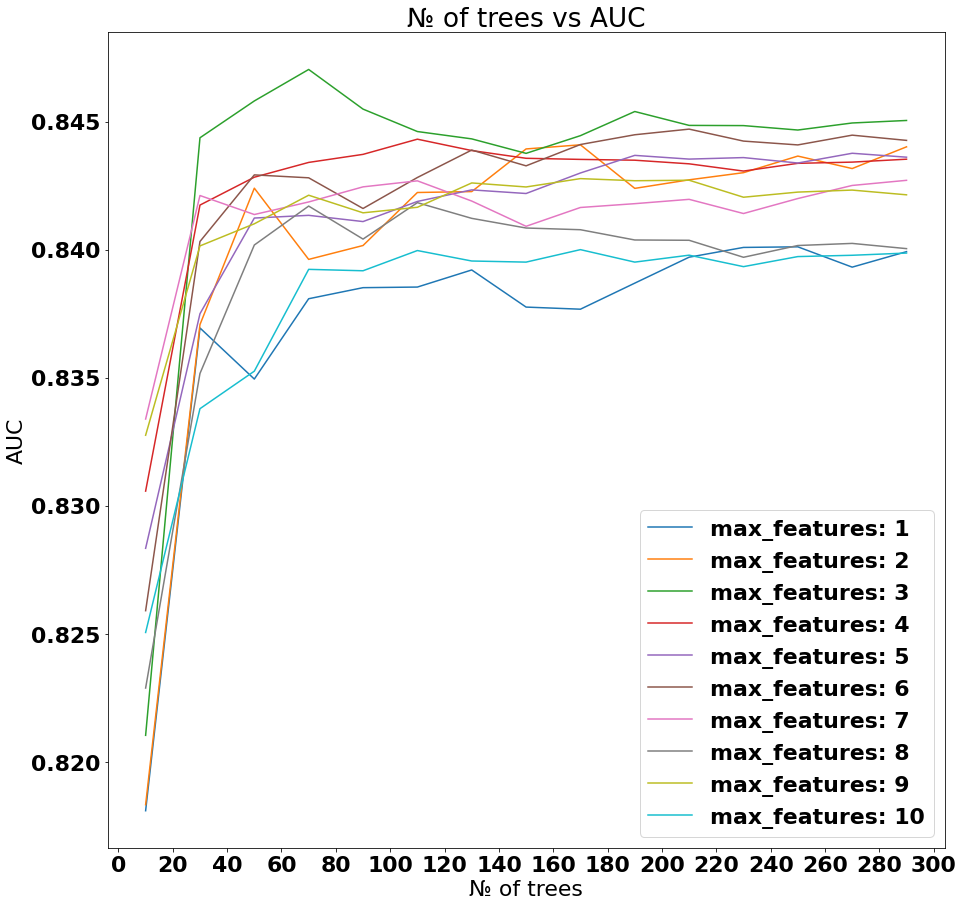

In [344]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


trees = list(range(10, 301, 20))

plt.figure(figsize=(15, 15))

plt.plot(trees, all_aucs[1], label='max_features: 1')
plt.plot(trees, all_aucs[2], label='max_features: 2')
plt.plot(trees, all_aucs[3], label='max_features: 3')
plt.plot(trees, all_aucs[4], label='max_features: 4')
plt.plot(trees, all_aucs[5], label='max_features: 5')
plt.plot(trees, all_aucs[6], label='max_features: 6')
plt.plot(trees, all_aucs[7], label='max_features: 7')
plt.plot(trees, all_aucs[8], label='max_features: 8')
plt.plot(trees, all_aucs[9], label='max_features: 9')
plt.plot(trees, all_aucs[10], label='max_features: 10')


plt.xticks(range(0, 301, 20))
plt.title('№ of trees vs AUC')
plt.xlabel('№ of trees')
plt.ylabel('AUC')


plt.legend()
plt.show()

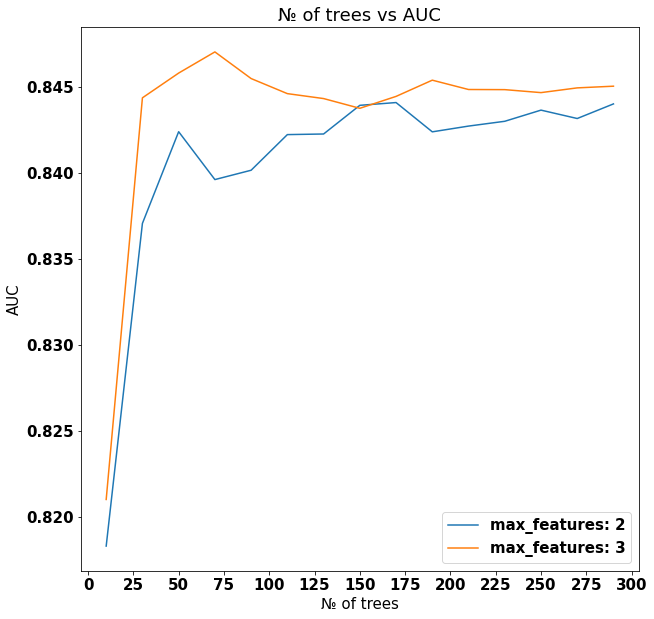

In [345]:
font = {'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


trees = list(range(10, 301, 20))

plt.figure(figsize=(10, 10))

plt.plot(trees, all_aucs[2], label='max_features: 2')
plt.plot(trees, all_aucs[3], label='max_features: 3')


plt.xticks(range(0, 301, 25))
plt.title('№ of trees vs AUC')
plt.xlabel('№ of trees')
plt.ylabel('AUC')

plt.legend()
plt.show()

# Using Random Forest model

In [346]:
# making prediction with `valid` dataset to compare next
# with `test` one and see whether model overfits or not
rf = RandomForestClassifier(n_estimators=80, max_features=3,
                            max_depth=10, min_samples_leaf=5,
                            random_state=1)
rf.fit(X_train, y_train)
y_rf_valid = rf.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_rf_valid)

0.847304883462383

In [347]:
y_train_full = (full_train.status == 'default').values
y_test = (df_test.status == 'default').values

del full_train['status']
del df_test['status']

In [348]:
df.isnull().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [349]:
dict_full_train = full_train.to_dict(orient='records')
dict_df_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_df_test)

In [350]:
rf = RandomForestClassifier(n_estimators=80, max_features=3,
                            max_depth=10, min_samples_leaf=5,
                            random_state=1)
rf.fit(X_full_train, y_train_full)
y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [351]:
f"{round(roc_auc_score(y_test, y_pred_rf), 4) * 100}%"

'84.49%'

# XGB Boost

In [352]:
def parse_model(output):
    tree = []
    aucs_train = []
    aucs_val = []
    
    for i in output.stdout.strip().split('\n'):
        it, train, valid = i.split('\t')
        it = int(it.strip('[]'))
        train = float(train.split(':')[1])
        valid = float(valid.split(':')[1])
        
        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(valid)
    
    return tree, aucs_train, aucs_val

In [353]:
dtrain = xgb.DMatrix(X_train, label=y_train,
                     feature_names=dv.feature_names_)

dvalid = xgb.DMatrix(X_valid, label=y_valid,
                    feature_names=dv.feature_names_)

In [354]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

<h3>Use best params. from the previous chapter</h3>

In [355]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model_xgb = xgb.train(xgb_params, dtrain, evals=watchlist,
                      verbose_eval=10, num_boost_round=500)

In [356]:
tree, aucs_train, aucs_valid_mf_05 = parse_model(output)
print(f"max AUC: {max(aucs_valid_mf_05)}")
print(max(zip(aucs_valid_mf_05, tree)))

max AUC: 0.85141
(0.85141, 160)


In [357]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model_xgb = xgb.train(xgb_params, dtrain, evals=watchlist,
                      verbose_eval=10, num_boost_round=500)

In [358]:
tree, aucs_train, aucs_valid_mf_06 = parse_model(output)
print(f"max AUC: {max(aucs_valid_mf_06)}")
print(max(zip(aucs_valid_mf_06, tree)))

max AUC: 0.8503
(0.8503, 110)


In [359]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model_xgb = xgb.train(xgb_params, dtrain, evals=watchlist,
                      verbose_eval=10, num_boost_round=500)

In [360]:
tree, aucs_train, aucs_valid_mf_02 = parse_model(output)
print(f"max AUC: {max(aucs_valid_mf_02)}")
print(max(zip(aucs_valid_mf_02, tree)))

max AUC: 0.85939
(0.85939, 220)


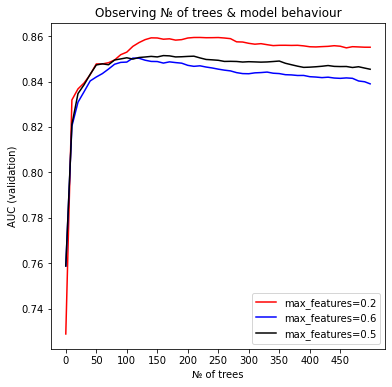

In [361]:
font = {'weight' : 'medium',
        'size'   : 10}

plt.rc('font', **font)

plt.figure(figsize=(6, 6))

plt.plot(tree, aucs_valid_mf_02, color='red', label='max_features=0.2')
plt.plot(tree, aucs_valid_mf_06, color='blue', label='max_features=0.6')
plt.plot(tree, aucs_valid_mf_05, color='black', label='max_features=0.5')

plt.title('Observing № of trees & model behaviour')
plt.xlabel('№ of trees')
plt.ylabel('AUC (validation)')


plt.xticks(range(0, 500, 50))

plt.legend()
plt.show()

# Using XGBoost model

In [362]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model_xgb = xgb.train(xgb_params, dtrain, evals=watchlist,
                      verbose_eval=10, num_boost_round=220)

In [363]:
tree, aucs_train, aucs_valid_mf_08 = parse_model(output)
print(f"max AUC: {max(aucs_valid_mf_08)}")
print(max(zip(aucs_valid_mf_08, tree)))

max AUC: 0.85943
(0.85943, 219)


In [364]:
y_predValid = model_xgb.predict(dvalid)

In [365]:
roc_auc_score(y_valid, y_predValid)

0.8594320239792891

# Final results

In [366]:
# let's use full_train & test
dFulltrain = xgb.DMatrix(X_full_train, label=y_train_full,
                         feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test,
                    feature_names=dv.feature_names_)

In [367]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

trees = 220

model_xgb = xgb.train(xgb_params, dFulltrain, num_boost_round=trees)

<h4>We need to compare with above results of valid dataset
    to see whether the model overfits or not
</h4>

In [368]:
y_xgb_final = model_xgb.predict(dtest)
f"{round(roc_auc_score(y_test, y_xgb_final), 4)*100}%"

# No overfitting: 85.94 vs 85.77

'85.77%'